In [145]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
import control as ct
from scipy.signal import square,sawtooth

In [146]:
import control as ct
Ts = 0.02                   # TEMPO DE AMOSTRAGEM!!
Kc =  1.50              # Nosso controlador 
a =   7.69             # Nossos zeros
 
Gc = ct.tf([Kc*1,Kc*a],[1,0])     # Função de transferência          
Gc

TransferFunction(array([ 1.5  , 11.535]), array([1, 0]))

In [147]:
Gz = ct.c2d(Gc,Ts, 'tustin')

print('Função de Transferência do controlador: \n', Gz)

Função de Transferência do controlador: 
 
1.615 z - 1.385
---------------
     z - 1

dt = 0.02




Estabelecendo conexão.

Iniciando coleta.

Fim da coleta.


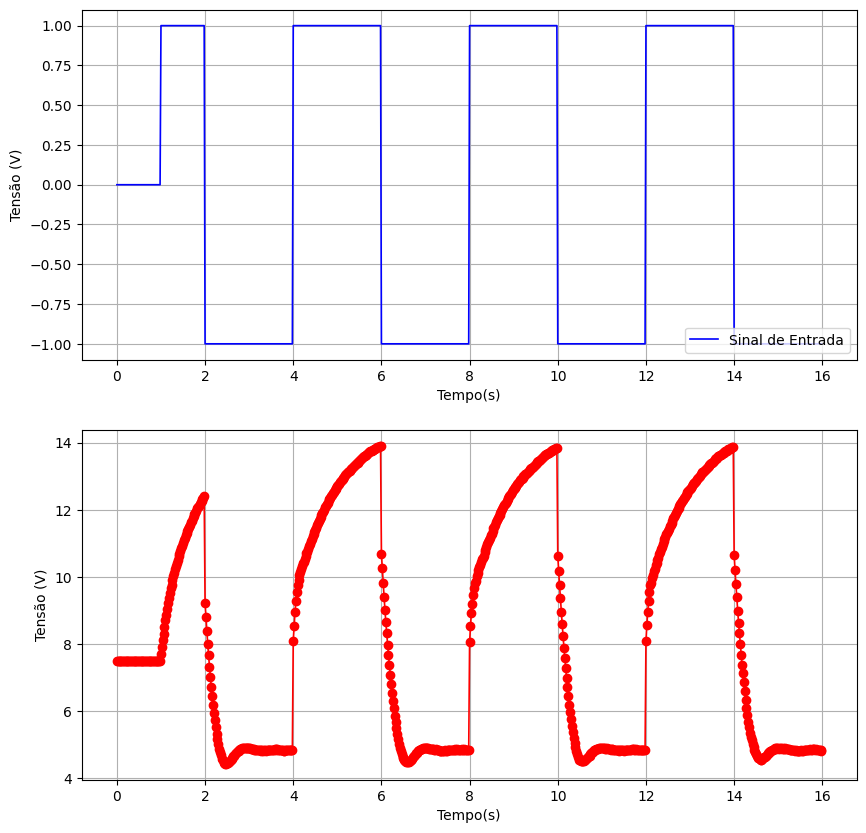

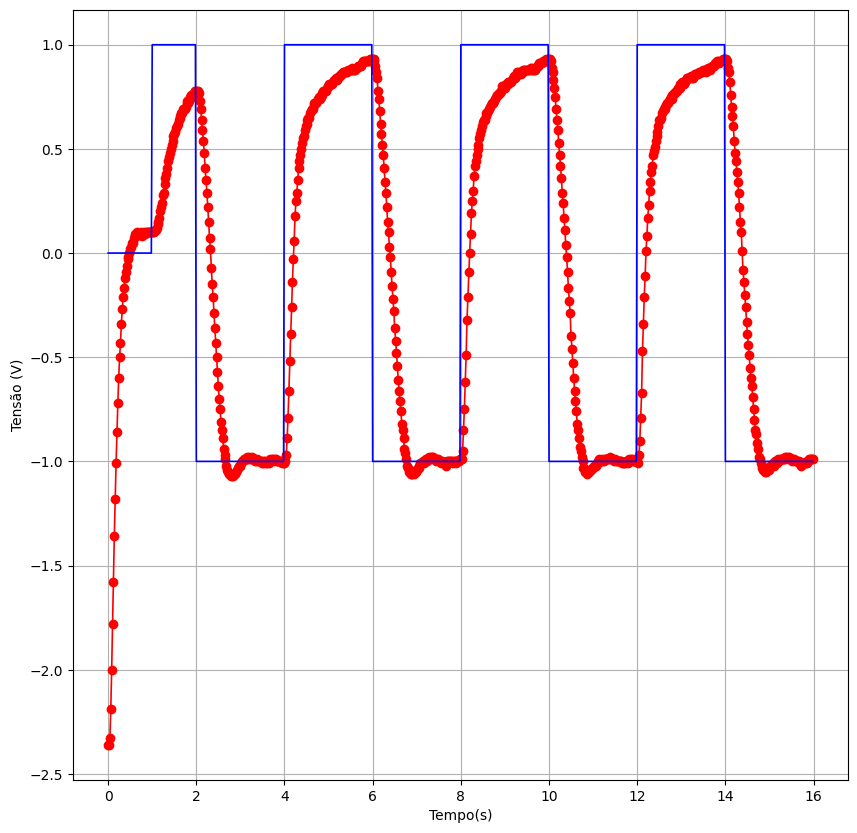

In [148]:
import serial
import numpy as np
import matplotlib.pyplot as plt
import time as t
from scipy.signal import square,sawtooth


##########################################
# Tensão de alimentação da bancada
amplitude_maxima = 15

numAmostras = 800
tempo = np.zeros(numAmostras)
y = np.zeros(numAmostras)

Ts = 0.02       
fre = 0.25                    # Freq
Amplitude = 1              # Amplitude
ponto_de_operacao = 7.5       # Bancada 05  
 
nivel_dc_saida = 2.36        # Bancada 05

#a = 2*np.ones(int(numAmostras/2))
#b = 4*np.ones(int(numAmostras/2))
#u = np.concatenate([a,b]) #degrau
r = np.zeros(numAmostras)
u = np.zeros(numAmostras)
e = np.zeros(numAmostras)
delta_u = np.zeros(numAmostras)

toc = np.zeros(numAmostras)
######################



for n in range(numAmostras):
    #r[n] = prbs[n] #+ ponto_de_operacao
  r[n] = Amplitude*square(2*np.pi*fre*n*Ts) #ponto_de_operacao
    # r[n] = Amplitude*sawtooth(2*np.pi*fre*n*Ts) + setpoint
    # r[n] = Amplitude*np.sin(2*np.pi*fre*n*Ts) + setpoint
    # r[n] = u[n]

print('\nEstabelecendo conexão.')
conexao = serial.Serial(port='COM16', baudrate=9600, timeout=0.005)


t.sleep(1)
print('\nIniciando coleta.')

##_____________ Loop principal de controle _____________##
nivel_dc_entrada = ponto_de_operacao
  #Gz = ct.c2d(Gc,Ts, 'tustin')
  #b0 = Gz.num[0][0][0]
  #b1 = Gz.num[0][0][1]


for n in range(numAmostras):
    tic = t.time()

    if (conexao.inWaiting() > 0):
        y[n] = conexao.readline().decode()

    # remove o nivel_dc_saida
    sinal_medido = y[n] - nivel_dc_saida
    
    # calcula o erro
    e[n] = r[n] - sinal_medido

    # primeiras 50 amostras
    if (n<50):
      u[n] = nivel_dc_entrada
      r[n] = 0.0
    else:
      delta_u[n] = delta_u[n-1] + 1.615*e[n] - 1.385*e[n-1]
      u[n] = nivel_dc_entrada + delta_u[n]   

    if (u[n] > amplitude_maxima):
      sinal_PWM = 255
    else:
      sinal_PWM = ((u[n])*255)/amplitude_maxima

    # sinal_PWM deve ser um número inteiro entre 0 e 255  
    conexao.write(str(round(sinal_PWM)).encode())
    
    t.sleep(Ts)
    
    if (n > 0):
        tempo[n] = tempo[n-1] + Ts
    toc[n] = t.time() - tic
t.sleep(1)
conexao.write('0'.encode())
print('\nFim da coleta.')                                               
conexao.close() 

plt.figure(figsize=(10,10))                                         
plt.subplot(211)                                                                  
plt.plot(tempo,r,'-b',linewidth=1.2)                                         
plt.xlabel('Tempo(s)')                                                       
plt.ylabel('Tensão (V)')                        
plt.grid()                                                                         
#plt.title('Onda Quadrada - Malha Aberta')                                          
plt.legend(loc='lower right', labels=('Sinal de Entrada','Sinal de Saída'))                                
                        
plt.subplot(212)                             
#plt.plot(tempo,r,'-b',tempo,y,'-r',linewidth=1.2)                         
plt.plot(tempo,u,'-ro',linewidth=1.2)                   
plt.xlabel('Tempo(s)')                        
plt.ylabel('Tensão (V)')                                                            
plt.grid()                                                     
# plt.title('Tensão de Saída - Malha Aberta')
plt.show()                                                                   
                
plt.figure(figsize=(10,10))                                 
#plt.plot(tempo,r,'-b',tempo,y,'-r',linewidth=1.2)
plt.plot(tempo, y-nivel_dc_saida,'-ro', tempo, r,'-b',linewidth=1.2)                                   
plt.xlabel('Tempo(s)')                                                                                                                                           
plt.ylabel('Tensão (V)')                                                                      
plt.grid()                                                                    
# plt.title('Tensão de Saída - Malha Aberta')
plt.show() 

#dados=np.stack((tempo,r,y, u),axis=-1)                                                                                                                   
#np.savetxt("C:/Users/User/Documents/2023.2/Laboratório de Controle/08-05/dados/dadoskp.csv", dados, delimiter=";")  
#np.savetxt("C:/Users/User/Documents/2023.2/Laboratório de Controle/relatório_6/dadosPI.csv", dados, delimiter=";")
                                 

